In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# A/B-тестирование

> Часть курса <a href="https://docs.microsoft.com/ru-ru/learn/modules/compare-two-samples-by-bootstrapping/">«Основы обработки и анализа данных»</a> от Microsoft с переработанными примерами под библиотеку `pandas`.

В современной аналитике данных решение о том, взяты ли две числовые выборки из одного и того же исходного распределения, называется *A/B-тестированием*. Название связано с метками двух выборок: A и B.

Разберем применение этого метода на примере. Данные взяты из выборки новорожденных в одной из крупной сети больниц. Мы будем работать с ней как с простой случайной выборкой, хотя процесс ее формирования проводился в несколько этапов. Информацию о более крупном наборе данных, из которого взята эта выборка, см. в книге Stat Labs Деборы Нолан (Deborah Nolan) и Терри Спида (Terry Speed).

## Курящие и некурящие

Таблица `births` содержит следующие переменные для 1174 пар "мать — ребенок": вес ребенка при рождении в унциях, гестационный возраст в днях, возраст матери (полных лет), рост матери в дюймах, вес во время беременности в фунтах, а также сведения о том, курила ли мать во время беременности.

In [2]:
births = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/baby.csv')
births

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
...,...,...,...,...,...,...
1169,113,275,27,60,100,False
1170,128,265,24,67,120,False
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False


Одна из целей этого исследования — определить, влияет ли курение матери на вес ребенка при рождении. Посмотрим, что можно сказать о двух переменных.

Для начала выберем только `Birth Weight` и `Maternal Smoker`. Среди женщин в выборке 715 некурящих и 459 курящих.

In [3]:
smoking_and_birthweight = births[['Maternal Smoker', 'Birth Weight']]

In [4]:
smoking_and_birthweight.groupby('Maternal Smoker').count()

,Birth Weight
Maternal Smoker,
False,715
True,459


Посмотрим на распределение веса при рождении у детей некурящих матерей по сравнению с детьми курящих матерей. Чтобы создать две пересекающиеся гистограммы, воспользуемся `hist` вспомогательным `group` аргументом — меткой или индексом столбца. Сначала сгруппируем строки по этому столбцу, а затем построим для каждой из них гистограмму.

In [6]:
smoking_and_birthweight['Birth Weight']

0       120
1       113
2       128
3       108
4       136
       ... 
1169    113
1170    128
1171    130
1172    125
1173    117
Name: Birth Weight, Length: 1174, dtype: int64

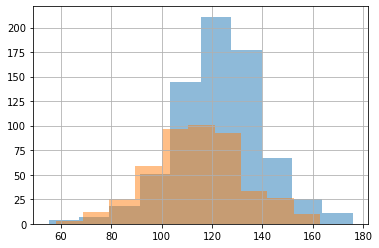

In [7]:
smoking_and_birthweight.groupby(['Maternal Smoker'])['Birth Weight'].hist(alpha=0.5);

Распределение веса при рождении у детей, чьи матери курили, смещено немного влево по сравнению с распределением, соответствующим некурящим матерям. Вес при рождении у детей, чьи матери курили, в среднем ниже, чем вес у детей, родившихся у некурящих женщин.

В результате возникает вопрос, что означает эта разница — только случайную вариацию или разницу в распределениях в более крупной генеральной совокупности. Возможно ли, что в генеральной совокупности никакой разницы между двумя этим распределениями нет, а разница, которую мы наблюдаем в выборке, относится только к случайно выбранным матерям?

## Гипотеза
Чтобы ответить на этот вопрос, проверим гипотезу. Согласно модели вероятности, которую мы будем тестировать, никакой фундаментальной разницы в генеральных совокупностях нет, а распределения в выборках различаются по чистой случайности.

Это называется "нулевая гипотеза". Нам необходимо понять, как смоделировать полезную статистику по этой гипотезе. Но для начала просто сформулируем две логичные гипотезы.

__Нулевая гипотеза.__ _В популяции распределение значений веса детей при рождении одинаково и для генеральной совокупности, и для курящих матерей. Разница в конкретной выборке случайна._

__Альтернативная гипотеза.__ _В генеральной совокупности дети, родившиеся у курящих женщин, в среднем весят при рождении меньше, чем дети, чьи матери не курят._

## Статистический критерий
Альтернативная гипотеза сравнивает средний вес при рождении в двух группах и утверждает, что в группе курящих матерей этот показатель ниже. Таким образом, для нас будет разумно использовать в качестве статистического критерия разность между средними показателями двух этих групп.

Для этого мы произведем вычисление: "средний вес в группе курящих — средний вес в группе некурящих". Маленькие (т. е. большие отрицательные) значения статистического критерия говорят о том, что верна альтернативная гипотеза.

Наблюдаемое значение статистического критерия составляет около -9,27 унции.

In [8]:
means_table = smoking_and_birthweight.groupby('Maternal Smoker').agg(np.average)
means_table

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


In [9]:
observed_difference = np.diff(means_table['Birth Weight'])[0]
observed_difference

-9.266142572024918

Вычислим такие разницы снова в моделях, представленных ниже, и определим таким образом функцию для решения данной задачи. Функция принимает три аргумента:

- имя таблицы данных;
- метка столбца, содержащего числовую переменную, среднее значение которой нас интересует;
- метка столбца, содержащего логическую переменную для группирования.

Она возвращает разность между средними арифметическими группы `True` и группы `False`.

In [10]:
def difference_of_means(table, label, group_label):
    reduced = table[[label, group_label]]
    means_table = reduced.groupby(group_label).mean()
    return np.diff(means_table[label])[0]

Чтобы проверить, работает ли функция, рассчитаем с ее помощью наблюдаемую разность между средними арифметическими двух входящих в выборку групп.

In [11]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

Мы получим значение, равное вычисленному ранее значению `observed_difference`.

# Прогнозирование статистики по нулевой гипотезе
Чтобы увидеть, как должен измениться статистический показатель, если нулевая гипотеза верна, нам нужно понять, как смоделировать статистический критерий по этой гипотезе. Для этого можно использовать метод на основе случайных перестановок.

Если бы разницы между двумя распределениями в исходной генеральной совокупности не было, то наличие у веса при рождении метки `True` или `False`, связанной с курением матери, не влияло бы на среднее значение. Идея в том, чтобы перераспределить все эти метки между матерями случайным образом. Это называется _случайной перестановкой_.

Рассмотрим разность средних арифметических двух новых групп: средний вес детей, матери которых были случайным образом помечены как курящие, и средний вес детей, матери которых были случайным образом помечены как некурящие. Это моделирование значения статистического критерия по нулевой гипотезе.

Посмотрим, как это работает. Лучше всего начинать с данных.

In [12]:
smoking_and_birthweight

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136
...,...,...
1169,False,113
1170,False,128
1171,True,130
1172,False,125


В таблице 1174 строки. Чтобы перемешать все метки, сделаем случайную выборку из 1174 строк без замены. Такая выборка будет включать все строки таблицы в случайном порядке.

In [14]:
shuffled_labels = smoking_and_birthweight.sample(replace=True, frac=1) \
                                  .reset_index()['Maternal Smoker']
shuffled_labels.name = 'Shuffled Label'

In [15]:
original_and_shuffled = pd.concat([smoking_and_birthweight, shuffled_labels], axis=1)
original_and_shuffled

,Maternal Smoker,Birth Weight,Shuffled Label
0,False,120,False
1,False,113,True
2,True,128,False
3,True,108,True
4,False,136,True
...,...,...,...
1169,False,113,True
1170,False,128,True
1171,True,130,True
1172,False,125,True


Теперь у матери каждого ребенка появилась случайная метка о факте курения в столбце `Shuffled Label`, в то время как исходная метка указана в столбце `Maternal Smoker`. Если нулевая гипотеза верна, любые случайные перетасовки меток должны быть одинаково вероятны.

Теперь посмотрим, как различаются средние показатели веса в двух группах со случайными метками.

In [16]:
original_and_shuffled

,Maternal Smoker,Birth Weight,Shuffled Label
0,False,120,False
1,False,113,True
2,True,128,False
3,True,108,True
4,False,136,True
...,...,...,...
1169,False,113,True
1170,False,128,True
1171,True,130,True
1172,False,125,True


In [17]:
shuffled_only = original_and_shuffled.drop('Maternal Smoker', axis=1)
shuffled_group_means = shuffled_only.groupby('Shuffled Label').mean()
shuffled_group_means

,Birth Weight
Shuffled Label,
False,119.303401
True,119.728929


Средние значения двух случайно выбранных групп намного более близки, чем средние значения двух исходных групп. Для определения двух разностей можно использовать функцию `difference_of_means`.

In [18]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

0.42552802442162374

In [19]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

Но не может ли быть так, что при другом распределении разность между средними показателями групп будет больше? Чтобы определить такую вероятность, нужно смоделировать эту разность много раз.

Как обычно, для начала определим функцию, моделирующую единое значение статистического критерия по нулевой гипотезе. Для этого нужно собрать только код, который мы написали выше. Но, так как в дальнейшем мы собираемся использовать этот процесс для сравнения средних арифметических других переменных, мы определим функцию, которая принимает три аргумента:

- имя таблицы данных;
- метка столбца, содержащего числовую переменную;
- метка столбца, содержащего логическую переменную для группирования.

Эта функция возвращает разность между средними арифметическими двух групп, образованных в результате случайного перераспределения меток.

In [20]:
def one_simulated_difference(table, label, group_label):
    shuffled_labels = table.sample(frac=1, replace=True) \
                           .reset_index()[group_label] \
                           .to_frame() \
                           .rename({group_label: 'Shuffled Label'}, axis=1)
    shuffled_table = pd.concat([table, shuffled_labels], axis=1)
    return difference_of_means(shuffled_table, label, 'Shuffled Label')

In [22]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

0.8071152812393052

## Тест на перестановку
Тесты на основе случайных перестановок данных называются _тестами на перестановку_. В этом примере мы выполняем подобный тест. В приведенной ниже ячейке мы смоделируем статистический критерий — разность между средними значениями двух групп, — повторим ее много раз и соберем полученные разности в массив.

In [23]:
repetitions = 5000
differences = np.empty((repetitions, 1))

for i in np.arange(repetitions):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences[i] = new_difference

Массив `differences` содержит 5000 смоделированных значений статистического критерия: разность между средним весом в группе курящих и средним весом в группе некурящих при присвоении меток случайным образом.

## Результат теста
Распределение этих 5000 значений показано на гистограмме ниже. Она показывает эмпирическое распределение статистического критерия, смоделированного по нулевой гипотезе. Это прогноз статистического критерия, исходя из нулевой гипотезы.

Observed Difference: -9.266142572024918


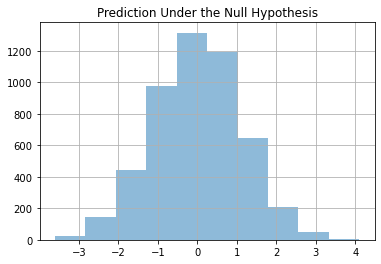

In [24]:
pd.DataFrame(differences, columns=['Difference Between Group Means']).hist(alpha=.5)
print('Observed Difference:', observed_difference)
plt.title('Prediction Under the Null Hypothesis');

Обратите внимание, что распределение сосредоточено вокруг 0. Это имеет смысл, поскольку, по нулевой гипотезе, среднее в двух группах должно быть в целом одинаково. Таким образом, разность между средними показателями групп должна быть около 0.

Наблюдаемая разность в исходной выборке составляет около 
−9,27 унции — на горизонтальной оси этой гистограммы такого показателя просто нет. Наблюдаемое значение статистики и прогнозируемое поведение статистики по нулевой гипотезе не совпадают.

Из этого следует, что, согласно данным, верна альтернативная, а не нулевая гипотеза. Средний вес при рождении у детей, чьи матери курят, меньше, чем у тех, чьи матери не курят.

Если вы хотите вычислить эмпирическое P-значение, помните, что низкие значения статистики поддерживают альтернативную гипотезу.

In [25]:
empirical_P = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_P

0.0

Эмпирическое P-значение равно 0, а значит, ни одна из 5000 выборок с перестановкой не показала разность –9,27 или меньше. И это только приближение. Точная вероятность получения разности в этом диапазоне не равна 0, но при этом ничтожно мала.

## Другой тест на перестановку
Этот же метод можно использовать для сравнения других атрибутов курящих и некурящих матерей, например возраста. Гистограммы возраста двух групп показывают, что в данной выборке курящие матери обычно моложе.

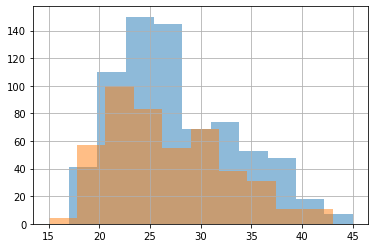

In [26]:
smoking_and_age = births[['Maternal Smoker', 'Maternal Age']]
smoking_and_age.groupby(['Maternal Smoker'])['Maternal Age'].hist(alpha=0.5);

Наблюдаемая разность среднего возраста составляет около -0,8 года.

In [27]:
observed_age_difference = difference_of_means(births, 'Maternal Age', 'Maternal Smoker')
observed_age_difference

-0.8076725017901509

Помните, что эта разность вычисляется как средний возраст курящих минус средний возраст некурящих. Отрицательный знак показывает, что в среднем курящие моложе.

Случайна ли эта разность или она отражает различие в генеральной совокупности?

Как и прежде, для ответа на этот вопрос можно использовать тест на перестановку. Если исходные распределения возрастов в двух группах одинаковы, то эмпирическое распределение разности в выборках с перестановкой покажет, как изменится статистика при случайном распределении.

In [28]:
repetitions = 5000
age_differences = np.zeros(repetitions)

for i in np.arange(repetitions):
    new_difference = one_simulated_difference(births, 'Maternal Age', 'Maternal Smoker')
    age_differences[i] = new_difference

Наблюдаемая разность находится в хвосте эмпирического распределения разностей, смоделированных по нулевой гипотезе.

Observed Difference: -0.8076725017901509


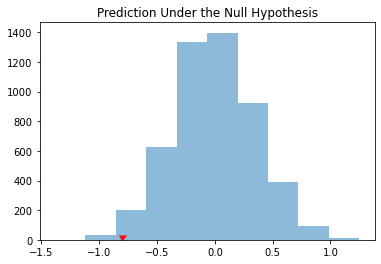

In [29]:
plt.hist(age_differences, alpha=.5)
plt.plot(observed_age_difference, 0, marker=7, markersize=7, color='red')
plt.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_age_difference)

Эмпирическое P-значение теста — это доля смоделированных разностей, которая равна наблюдаемой разности или меньше. Это связано с тем, что низкие значения разности показывают, что верна альтернативная гипотеза, согласно которой курящие в среднем моложе.

In [30]:
empirical_P = np.count_nonzero(age_differences <= observed_age_difference) / repetitions
empirical_P

0.011

Эмпирическое P-значение составляет около 1%, а значит, результат статистически значимый. Тест подтверждает гипотезу о том, что курящие в среднем моложе.

# Дифлейтгейтский скандал
18 января 2015 г. "Индианаполис Колтс" и "Патриоты Новой Англии" встретились на чемпионате Американской футбольной конференции (АФК), чтобы определить, какая из этих команд примет участие в Суперкубке. После матча появились заявления о том, что "Патриоты" играли мячами, надутыми меньше, чем того требует регламент, из-за чего мячи были мягче. В результате они могли получить преимущество, поскольку более мягкие мячи легче ловить.

В течение нескольких недель весь мир американского футбола был поглощен обвинениями, опровержениями, теориями и подозрениями, а пресса назвала этот скандал Дифлейтгейтским по аналогии с Уотергейтским политическим скандалом 1970-х годов. Национальная футбольная лига (НФЛ) организовала независимый анализ. В этом примере мы проведем свой собственный анализ данных.

Давление часто измеряют в фунтах на квадратный дюйм (PSI). Согласно правилам НФЛ, давление в игровых мячах должно составлять от 12,5 до 13,5 psi. Каждая команда играет 12 мячами. Команды сами отвечают за поддержание давления в своих мячах, но мячи проверяют арбитры. Перед началом матча АФК давление во всех мячах "Патриотов" составляло около 12,5 psi. У "Колтс" большинство мячей было надуто до 13,0 psi. При этом данные о давлении в мячах перед игрой нигде не зафиксировали.

Во время второго периода игроки "Колтс" перехватили мяч "Патриотов". На скамейке запасных они замерили давление в мяче и определили, что оно было меньше обязательных 12,5 psi. Об этом сразу же сообщили арбитрам.

В перерыве после второго периода все игровые мячи собрали на проверку. Два арбитра, Клит Блакемэн (Clete Blakeman) и Дирол Прайолу (Dyrol Prioleau), замерили давление в каждом из мячей.

Вот эти данные. Каждая строка соответствует одному мячу. Давление измерено в psi. Мяч "Патриотов", который перехватили "Колтс", в перерыве после второго периода не проверялся. Не проверили и большинство мячей "Колтс" — арбитрам просто не хватило времени и пришлось вернуть мячи для возобновления матча.

In [31]:
football = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/deflategate.csv')
football

,Team,Blakeman,Prioleau
0,Patriots,11.50,11.80
1,Patriots,10.85,11.20
2,Patriots,11.15,11.50
3,Patriots,10.70,11.00
4,Patriots,11.10,11.45
5,Patriots,11.60,11.95
6,Patriots,11.85,12.30
7,Patriots,11.10,11.55
8,Patriots,10.95,11.35
9,Patriots,10.50,10.90


По каждому из 15 проверенных мячей два арбитра получили разные результаты. Нередко повторные измерения одного и того же объекта дают другие результаты, особенно если их делают разные люди. В связи с этим каждому мячу мы присвоим среднее значение двух измерений, сделанных для этого мяча.

In [32]:
football = football.eval('Combined = (Blakeman + Prioleau) / 2') \
                                   .drop(['Blakeman', 'Prioleau'], axis=1)
football

,Team,Combined
0,Patriots,11.650
1,Patriots,11.025
2,Patriots,11.325
3,Patriots,10.850
4,Patriots,11.275
5,Patriots,11.775
6,Patriots,12.075
7,Patriots,11.325
8,Patriots,11.150
9,Patriots,10.700


На первый взгляд очевидно, что давление в мячах "Патриотов" было меньше, чем в мячах "Колтс". Поскольку в ходе игры небольшое выпускание воздуха из мячей вполне естественно, независимые аналитики решили рассчитать снижение давления с начала игры. Вспомним, что перед матчем давление в мячах "Патриотов" составляло около 12,5 psi, а в мячах "Колтс" — 13,0 psi. Таким образом, снижение давления в мячах "Патриотов" рассчитали как 12,5 минус давление после второго периода, а снижение давления в мячах "Колтс" — как 13,0 минус давление после второго периода.

Чтобы рассчитать снижения давления в каждом мяче, создадим массив начальных значений. Для этого нам потребуется массив, состоящий из 11 значений, каждое из которых равно 12,5, и еще один массив, состоящий из четырех значений, каждое из которых равно 13. Мы будем использовать функцию NumPy `np.ones`, которая принимает в качестве аргумента значение `count` и возвращает массив из соответствующего количества элементов, каждый из которых равен 1.

In [33]:
patriots_start = 12.5 * np.ones(11)
colts_start = 13 * np.ones(4)
start = np.append(patriots_start, colts_start)
start

array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
       13. , 13. , 13. , 13. ])

Снижение давления в каждом футбольном мяче — это разность между начальным давлением и комбинированным результатом измерения давления.

In [34]:
drop = start - football[['Combined']].values.ravel()
football['Pressure Drop'] = drop
football

,Team,Combined,Pressure Drop
0,Patriots,11.650,0.850
1,Patriots,11.025,1.475
2,Patriots,11.325,1.175
3,Patriots,10.850,1.650
4,Patriots,11.275,1.225
5,Patriots,11.775,0.725
6,Patriots,12.075,0.425
7,Patriots,11.325,1.175
8,Patriots,11.150,1.350
9,Patriots,10.700,1.800


Похоже, что в мячах "Патриотов" давление снизилось сильнее, чем в мячах "Колтс". Определим теперь среднее снижение давления в каждой из двух групп. Комбинированные оценки нам больше не нужны.

In [35]:
football = football.drop('Combined', axis=1)
football.groupby('Team').mean()

,Pressure Drop
Team,
Colts,0.468750
Patriots,1.202273


Среднее снижение давления в мячах "Патриотов" составило около 1,2 psi, а в мячах "Колтс" — 0,47 psi.

Вопрос в том, почему давление в мячах "Патриотов" снизилось в среднем сильнее, чем в мячах "Колтс". Возможно ли, что это случайность?

## Гипотеза
Как здесь проявляется случайность? Никаких случайных выборок здесь нет. Однако мы можем составить вероятностную модель, предположив, что 11 снижений давления в мячах "Патриотов" представляют собой случайную выборку 11 из всех 15 снижений давления, из которых четыре оставшихся — это снижение давления в мячах "Колтс". Это полностью определенная вероятностная модель, в которой можно смоделировать данные. И это же нулевая гипотеза.

В качестве альтернативной гипотезы можно принять такую позицию, что давление в мячах "Патриотов" в среднем снизилось слишком сильно, чтобы считать это случайной выборкой из всех снижений давления.

## Статистический критерий
Логичный статистический критерий — это разность между двумя средними значениями снижения давления, которую мы вычислим по формуле: среднее снижение давления у "Патриотов" – среднее снижение давления у "Колтс". Большие значения этого статистического критерия говорят в пользу альтернативной гипотезы.

In [36]:
observed_means = football.groupby('Team').mean()['Pressure Drop']
observed_difference = np.diff(observed_means)[0]
observed_difference

0.733522727272728

Положительная разность отражает тот факт, что среднее снижение давления в мячах "Патриотов" было больше, чем в мячах "Колтс".

Функция `difference_of_means` принимает три аргумента:

- имя таблицы данных;
- метка столбца, содержащего числовую переменную, среднее значение которой нас интересует;
- метка столбца, содержащего метки двух групп.

Она возвращает разность между средними арифметическими двух групп.

In [37]:
difference_of_means(football, 'Pressure Drop', 'Team')

0.733522727272728

Обратите внимание на то, что разность вычисляется как снижение давления в мячах "Патриотов" минус снижение давления в мячах "Колтс", как и выше.

## Прогнозирование статистики по нулевой гипотезе
Если бы нулевая гипотеза была верна, было бы неважно, какие мячи относятся к "Патриотам", а какие к "Колтс". Распределения двух наборов данных по снижению давления были бы одинаковы. Мы можем это смоделировать, переставив метки команд в случайном порядке.

In [38]:
shuffled_labels = football.sample(frac=1, replace=True).reset_index()['Team']
shuffled_labels.name = 'Shuffled Label'

original_and_shuffled = pd.concat([football, shuffled_labels], axis=1)
original_and_shuffled

,Team,Pressure Drop,Shuffled Label
0,Patriots,0.850,Colts
1,Patriots,1.475,Patriots
2,Patriots,1.175,Colts
3,Patriots,1.650,Patriots
4,Patriots,1.225,Patriots
5,Patriots,0.725,Colts
6,Patriots,0.425,Patriots
7,Patriots,1.175,Colts
8,Patriots,1.350,Colts
9,Patriots,1.800,Patriots


Как соотносятся средние значения групп?

In [41]:
difference_of_means(original_and_shuffled, 'Pressure Drop', 'Shuffled Label')

0.08055555555555494

In [42]:
observed_difference = difference_of_means(original_and_shuffled, 'Pressure Drop', 'Team')

Средние значения снижения давления в мячах двух команд при случайном распределении меток между мячами различаются меньше, чем тогда, когда мячи относились к тем группам, которые фактически использовали их во время игры.

## Тест на перестановку
Теперь перейдем к этапу, который вам уже знаком. Выполним повторные моделирования статистического критерия по нулевой гипотезе, используя многократную перестановку мячей и перераспределяя их между двумя командами случайным образом.

Снова воспользуемся функцией `one_simulated_difference`. С помощью этой функции создадим массив `differences`, содержащий 10 000 значений статистического критерия, смоделированных по нулевой гипотезе.

In [255]:
def difference_of_means(table, label, group_label):
    reduced = table[[label, group_label]]
    means_table = reduced.groupby(group_label).mean()
    try:
        return np.diff(means_table[label])[0]
    except IndexError:
        return means_table[label].sum()
        

def one_simulated_difference(table, label, group_label):
    shuffled_labels = table.sample(frac=1, replace=True) \
                           .reset_index()[group_label] \
                           .to_frame() \
                           .rename({group_label: 'Shuffled Label'}, axis=1)
    shuffled_table = pd.concat([table, shuffled_labels], axis=1)
    return difference_of_means(shuffled_table, label, 'Shuffled Label')

In [256]:
repetitions = 10000
differences = np.zeros(repetitions)

for i in np.arange(repetitions):
    new_difference = one_simulated_difference(football, 'Pressure Drop', 'Team')
    differences[i] = new_difference

## Результат теста
Чтобы вычислить эмпирическое P-значение, нужно вспомнить альтернативную гипотезу, которая заключается в том, что давление в мячах "Патриотов" снизилось слишком сильно, чтобы быть случайным.

Более сильное снижение давления в мячах "Патриотов" говорит в пользу альтернативной гипотезы. P-значение — это (вычисленная по нулевой гипотезе) вероятность получения статистического критерия, равного наблюдаемому значению 0,733522727272728 или выше.

In [257]:
empirical_P = np.count_nonzero(differences >= observed_difference) / 10000
empirical_P

0.0181

Это довольно небольшое P-значение. Для наглядности представим эмпирическое распределение статистического критерия по нулевой гипотезе, отметив наблюдаемую статистику на горизонтальной оси.

Observed Difference: 0.733522727272728
Empirical P-value: 0.0181


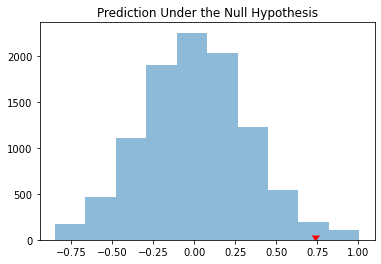

In [261]:
plt.hist(differences, alpha=.5)
plt.plot(observed_difference, 0, marker=7, markersize=7, color='red')
plt.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_difference)
print('Empirical P-value:', empirical_P)

Как и в предыдущих примерах этого теста, основная часть распределения сосредоточена вокруг 0. Согласно нулевой гипотезе, снижение давления в мячах "Патриотс" — это случайная выборка из всех 15 значений снижения давления в мячах, в т. ч. в мячах "Колтс". Следовательно, снижение давления в двух наборах должно быть в среднем одинаково, а значит, их разность должна быть около 0.

Однако наблюдаемое значение статистического критерия довольно сильно отличается от центра распределения. По любой разумной логике эмпирическое P-значение низкое. В связи с этим мы отклоняем нулевую гипотезу о случайности и приходим к выводу, что давление в мячах "Патриотов" снизилось слишком сильно, чтобы быть случайным.

Независимая исследовательская группа проанализировала данные несколькими разными способами с учетом законов физики. В итоговом отчете было сказано:
> Среднее снижение давления в игровых мячах 'Патриотов' превысило среднее снижение давления в мячах 'Колтс' на 0,45–1,02 psi с учетом различных возможных допущений в отношении устройств, которые использовались для выполнения измерений, и исходя из того, что исходное давление составляло 12,5 psi для 'Патриотов' и 13,0 psi для 'Колтс'.

Отчет комиссии НФЛ по результатам расследования в отношении матча Чемпионата АФК 18 января 2015 г.

Наш анализ показал, что давление в среднем снизилось на 0,73 psi, что примерно соответствует центру интервала 0,45–1,02 psi, а значит, согласуется с официальным анализом.

Помните, что наша проверка гипотез не устанавливает, почему разница не случайна. Установить причинно-следственные связи обычно намного сложнее, чем проверить гипотезы.

Но мир футбола в первую очередь интересуют именно они: вопрос был в том, было ли чрезмерное снижение давления в мячах "Патриотов" намеренным.

# Причинно-следственная связь

Наши методы сравнения двух выборок эффективное работают в анализе рандомизированных контролируемых экспериментов. Поскольку экспериментальная и контрольная группы назначаются в таких экспериментах случайным образом, различия в их результатах можно сравнивать со случайными результатами, которые имели бы место в отсутствие какого бы то ни было лечения. Если наблюдаемые различия будут более выражены, чем то, что можно было бы считать абсолютной случайности, мы получим доказательство причинно-следственной связи. Беспристрастное распределение участников между экспериментальной и контрольной группами позволяет относить различия в результатах двух этих групп на счет лечения.

Ключ к анализу рандомизированных контролируемых экспериментов — это точное понимание того, какую роль здесь играет вероятность. Оно позволит нам сформулировать четкую нулевую и альтернативную гипотезы. После этого мы сможем применить методы из предыдущих разделов для выполнения анализа.

Посмотрим, как это делается, на примере.

## Лечение хронической боли в спине, рандомизированное контролируемое исследование
Боль в пояснице у взрослых может плохо поддаваться лечению. Для ее лечения применяют широкий спектр методов, от кортикостероидов до акупунктуры. В ходе рандомизированного контролируемого исследования (РКИ) изучалась эффективность лечения ботулиническим токсином типа А. Ботулинический токсин — это нейротоксин белковой природы, вызывающий ботулизм; согласно Википедии, ботулотоксин — "сильнейший из известных науке токсинов". Существуют семь типов ботулинического токсина. Ботулинический токсин типа A — один из типов, которые могут вызывать у людей ботулизм, однако также применяется в медицине для лечения различных болезней, связанных с мышечными тканями. РКИ, который Фостер, Клапп и Джаббари (Foster, Clapp, and Jabbari) проанализировали в 2001 году, изучало его применение для лечения боли в пояснице.

31 пациента с болью в пояснице распределили случайным образом либо в экспериментальную, либо в контрольную группу (15 человек попали в первую, 16 — во вторую). Членам контрольной группы давали обычный физраствор, причем исследование было двойным слепым, т. е. ни врачи, ни пациенты не знали, в какую именно группу входит тот или иной пациент.

Через восемь недель после начала исследования 9 из 15 членов экспериментальной группы и 2 из 16 членов контрольной группы отметили облегчение боли (согласно тому определению, которым пользовались исследователи). Эти данные показаны в таблице `bta` и подтверждают, что лечение имело явную пользу.

In [262]:
bta = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/bta.csv')
bta.head()

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0


Напомним, что для проведения расчетов нужно сложить единицы и нули. Сумма единиц в контрольной группе — это количество членов контрольной группы, которые почувствовали облегчение боли. Среднее число единиц — это доля членов контрольной группы, которые почувствовали облегчение боли.

In [263]:
bta.groupby('Group').mean()

,Result
Group,
Control,0.125
Treatment,0.600


В экспериментальной группе 60 % пациентов почувствовали облегчение боли, а в контрольной — только 12,5 %. Ни у кого из пациентов не было побочных эффектов.

Это значит, что ботулинический токсин типа А показал себя лучше, чем физраствор. Однако этот вывод еще нельзя назвать убедительным. Поскольку пациенты распределялись между группами случайным образом, не могла ли эта разница быть случайной?

Чтобы в этом разобраться, нам нужно учесть вероятность того, что из 31 участника данного исследования кто-то был более способен к выздоровлению даже без помощи соответствующего лекарства. Что, если в экспериментальную группу случайно попала чрезмерно высокая доля таких пациентов? В этом случае результаты в экспериментальной группе могли оказаться лучше, чем в контрольной, даже если бы лечение было не эффективнее физраствора, который давали контрольной группе.

Чтобы учесть эту возможность, для начала тщательно выстроим модель вероятности.

## Потенциальные результаты
До того как пациентов случайным образом распределят на две группы, наш разум инстинктивно представляет себе два возможных варианта для каждого пациента: результат, который пациент получит, если попадет в экспериментальную группу, и результат, который он получит, если попадет в контрольную группу. Это два _потенциальных результата_ пациента.

Таким образом, мы получаем 31 потенциальный результат экспериментальной группы и 31 потенциальный результат контрольной группы. Вопрос в распределении каждого из этих двух наборов из 31 результата. Будет ли оно одинаковым или разным?

Ответить на этот вопрос мы пока не можем, поскольку не сможем увидеть все 31 значение в каждой группе. Мы видим только 16 случайным образом отобранных потенциальных результатов контрольной группы и результаты лечения _остальных_ 15 пациентов.

Вот как можно представить это наглядно. Каждый пациент получает билет, состоящий из двух половинок.

![](./media/causality1.png)

После случайного распределения мы видим правую половину билетов случайной выборки пациентов и левую половину билетов оставшихся пациентов.

![](./media/causality2.png)

В таблице `observed_outcomes` собраны сведения о возможных результатах каждого пациента, в которых невидимая часть каждого "билета" опущена. (Это просто еще один способ представления таблицы `bta`, которая содержит те же самые данные.)

In [264]:
observed_outcomes = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/observed_outcomes.csv')

In [265]:
observed_outcomes

,Group,Outcome if assigned treatment,Outcome if assigned control
0,Control,Unknown,1
1,Control,Unknown,1
2,Control,Unknown,0
3,Control,Unknown,0
4,Control,Unknown,0
5,Control,Unknown,0
6,Control,Unknown,0
7,Control,Unknown,0
8,Control,Unknown,0
9,Control,Unknown,0


## Гипотеза
Вопрос в том, имеет ли лечение какой-то эффект. С точки зрения таблицы `observed_outcomes` необходимо понять, отличается ли распределение 31 "экспериментального" значения в столбце 1 (включая неизвестные) от распределения 31 "контрольного" значения в столбце 2 (также включая неизвестные).

__Нулевая гипотеза.__ Распределение 31 потенциального "экспериментального" результата совпадает с распределением 31 потенциального "контрольного" результата. Ботулинический токсин типа A действует точно так же, как физраствор; разница в выборках абсолютно случайна.

__Альтернативная гипотеза.__ Распределение 31 потенциального "экспериментального" результата отличается от распределения 31 потенциального "контрольного" результата. Эффект от лечения не такой, как в контрольной группе.

В двух группах совокупно наблюдается 31 результат. Если нулевая гипотеза верна, то неважно, какой из этого 31 результата обозначен как "экспериментальный", а какой как "контрольный". Любое случайное подмножество в размере 16 из 31 значений может называться "контрольным", а остальные 15 — "экспериментальным".

Это можно смоделировать. Мы можем перемешать это 31 значение, разделить его на две группы из 16 и 15 значений и посмотреть, как изменятся распределения в этих двух группах. Поскольку данные отображаются в виде нулей и единиц, можно просто сравнить их соотношение.

Так мы поступали в процессе A/B-тестирования, которое рассматривалось в предыдущем блоке. Теперь выборка A — это контрольная группа, а выборка B — экспериментальная. Проведем тест, подробное описание всех шагов которого приводится ниже. Это должны быть те же самые шаги, из которых состоит A/B-тестирование.

## Статистический критерий
Если соотношения в группах отличаются, обратимся к альтернативной гипотезе о том, что исходные распределения различаются. Наш статистический критерий будет отражать разницу между соотношениями двух групп, т. е. абсолютное значение разности между ними.

Большие значения в статистике теста говорят в пользу альтернативной гипотезы.

Поскольку соотношения в группах равны 0,6 и 0,125, наблюдаемое значение статистического критерия составляет ∣0,6 – 0,125∣ = 0,475


In [266]:
bta.groupby('Group').mean()

,Result
Group,
Control,0.125
Treatment,0.600


In [267]:
observed_proportions = bta.groupby('Group').mean()['Result']
observed_distance = np.diff(observed_proportions)[0]
observed_distance

0.475

Как и раньше, определим функцию, которая принимает следующие аргументы:

- имя таблицы данных;
- метка столбца с числовой переменной;
- метка столбца с метками групп;

и возвращает абсолютную разность соотношений двух групп.

In [268]:
def distance(table, label, group_label):
    reduced = table[[label, group_label]]
    proportions = reduced.groupby(group_label).mean()[label]
    return abs(np.diff(proportions)[0])

In [269]:
distance(bta, 'Result', 'Group')

0.475

### Прогнозирование статистики по нулевой гипотезе
Мы можем смоделировать результаты по нулевой гипотезе, чтобы проверить, какой статистический критерий мы получим, если нулевая гипотеза верна.

### Получение одного значения статистического показателя
Выполним точно такое же моделирование, как в предыдущем блоке. Для начала перераспределим все метки групп случайным образом и назначим перетасованные метки результатам 0/1.

In [270]:
shuffled_labels = bta.sample(frac=1, replace=True).reset_index()['Group']
shuffled_labels.name = 'Shuffled Label'

bta_with_shuffled_labels = pd.concat([bta, shuffled_labels], axis=1)
bta_with_shuffled_labels

,Group,Result,Shuffled Label
0,Control,1.0,Control
1,Control,1.0,Treatment
2,Control,0.0,Treatment
3,Control,0.0,Control
4,Control,0.0,Control
5,Control,0.0,Treatment
6,Control,0.0,Control
7,Control,0.0,Treatment
8,Control,0.0,Control
9,Control,0.0,Control


Теперь можно узнать расстояние между двумя соотношениями после перетасовки меток.

In [271]:
distance(bta_with_shuffled_labels, 'Result', 'Shuffled Label')

0.2681818181818182

Оно должно отличаться от расстояния между двумя исходными соотношениями.

In [272]:
observed_distance = distance(bta_with_shuffled_labels, 'Result', 'Group')
observed_distance

0.475

## Тест на перестановку
Если мы снова перемешаем метки, насколько изменится новое расстояние? Чтобы ответить на этот вопрос, определим функцию, которая моделирует одно смоделированное значение расстояния согласно гипотезе случайной перестановки в пределах того же исходного распределения. Затем мы соберем 20 000 таких смоделированных значений в массив.

Как видите, мы делаем все то же самое, что и в предыдущих примерах теста на перестановку.

In [273]:
def one_simulated_distance(table, label, group_label):
    shuffled_labels = table.sample(frac=1, replace=True) \
                           .reset_index()[group_label] \
                           .to_frame() \
                           .rename({group_label: 'Shuffled Label'}, axis=1)
    shuffled_table = pd.concat([table, shuffled_labels], axis=1)
    return difference_of_means(shuffled_table, label, 'Shuffled Label')

In [274]:
repetitions = 20000
distances = np.zeros(repetitions)

for i in np.arange(repetitions):
    new_distance = one_simulated_distance(bta, 'Result', 'Group')
    distances[i] = new_distance

## Результат теста
Массив `distances` содержит 20 000 значений статистического критерия, смоделированных по нулевой гипотезе.

Чтобы найти значение P для теста, вспомним, что большие значения статистического критерия поддерживают альтернативную гипотезу. Таким образом, эмпирическое P-значение — это доля смоделированной статистики, которая равна наблюдаемой статистике или больше нее.

In [275]:
empirical_P = np.count_nonzero(distances >= observed_distance) / repetitions
empirical_P

0.00505

Это маленькое P-значение. Наблюдаемая статистика, показанная ниже в виде красной точки, находится в хвосте гистограммы статистических критериев, сформированных по нулевой гипотезе.

Результат статистически значимый. Тест говорит о том, что альтернативная гипотеза превалирует над нулевой. Доказательство подтверждает гипотезу о том, что лечение работает.

Observed Difference: 0.733522727272728
Empirical P-value: 0.5 %


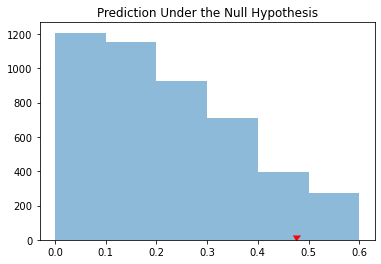

In [276]:
plt.hist(differences, bins=np.arange(0, 0.7, 0.1), alpha=.5)
plt.plot(observed_distance, 0, marker=7, markersize=7, color='red')
plt.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_difference)
print('Empirical P-value:', round(empirical_P, 4) * 100, '%')

В результатах исследования заявлено P-значение 0,009 или 0,9%, что ненамного отличается от нашего эмпирического значения.

## Причинно-следственная связь
Поскольку исследования были рандомизированными, тест подтверждает, что лечение оказывает определенное действие. Случайное распределение пациентов на две группы гарантирует, что на выводы о причинно-следственной связи не повлияет никакая вмешивающаяся переменная.

Если бы лечение назначалось не в случайном порядке, наш тест все равно бы указал на связь между лечением и конечным состоянием боли в пояснице у 31 пациента. При этом следует иметь в виду, что без рандомизации эта связь не могла бы означать, что на состояние боли в пояснице повлияло лечение. Например, если бы пациенты сами выбирали, принимать ли лечение, возможно, что те из них, кто испытывал более сильную боль, с большей вероятностью выбрали бы лечение и испытали бы ослабление боли даже без препарата. В этом случае наличие боли до проведения исследования считалось был вмешивающимся фактором при анализе.

## Метаанализ

При том что РКИ доказывает, что ботулинический токсин типа А помог пациентам, исследования с участием 31 пациента недостаточно для подтверждения эффективности медицинского лечения. И это не только из-за небольшого размера выборки. Результаты, полученные в этом разделе, действительны для 31 участвовавшего в исследовании пациента, однако нас интересует совокупность всех возможных пациентов. Если этот 31 пациент был выбран случайно из более крупной генеральной совокупности, наш доверительный интервал должен быть действителен и для всей этой популяции. Однако выборка не была случайной.

В 2011 году группа исследователей провела метаанализ исследований данного лечения. Это значит, что они нашли все доступные исследования подобных способов лечения боли в пояснице и просуммировали их совокупные результаты.

Исследований оказалось несколько, но лишь немногие их них можно было включить в анализ научно обоснованным образом: "Мы исключили данные 19 исследований из-за отсутствия рандомизации или из-за неполных или неопубликованных данных". Остались только три рандомизированных контролируемых исследования, одно из которых мы изучили в этом разделе. Оно получило наивысшую оценку среди всех исследований, которые рассматривались в это метаанализе (БП — боль в пояснице): "Мы обнаружили три исследования, изучавших преимущества применения БоНТ для лечения БП, но только одно имело низкий риск системной ошибки и включало пациентов с неспецифической БП (N = 31)".

Результатом метаанализа стал следующий вывод: "Существуют недостаточно достоверные признаки того, что инъекции БоНТ уменьшают боли и/или функцию лучше, чем инъекции физраствора, и действуют эффективнее акупунктуры или инъекций стероидов". ... Дальнейшие исследования могут значительно повлиять на оценку эффективности этого способа лечения и нашу уверенность. Дальнейшие исследования должны стандартизировать генеральные совокупности пациентов, протоколы лечения и группы сравнения, включать больше участников и результаты за более длительное время, анализ рентабельности и данные о клинической значимости результатов".

Подтверждение эффективности определенного способа лечения требует серьезной, тщательной работы. Важную часть этой работы составляет знание о том, как анализировать рандомизированные контролируемые исследования. Узнав, как это делается, вы получили хорошие возможности помочь медицинским и другим специалистам в установлении причинно-следственных связей.

# Бутстрэп

Специалист по анализу и обработке данных использует данные в случайной выборке для оценки неизвестного параметра. На основе выборки специалист по обработке и анализу данных вычисляет значение статистического критерия, который он будет использовать для оценки.

Вычислив наблюдаемое значение статистического критерия, специалист по обработке и анализу данных сможет просто представить его как оценку и пойти дальше. Он знает, что случайная выборка — это только одна из многочисленных возможных случайных выборок, а значит, эта оценка только одна из многочисленных вероятных оценок.

Насколько могут различаться эти оценки? Похоже, что для ответа на этот вопрос специалисту по обработке и анализу данных необходимо создать еще одну выборку из генеральной совокупности и вычислить новую оценку по этой выборке. Однако у него нет ресурсов для того, чтобы возвращаться к генеральной совокупности и делать еще одну выборку.

Похоже, ничего не поделаешь.

К счастью, способ решения этой задачи есть — это _бутстрэп_. Поскольку новые выборки из генеральной совокупности создать нельзя, бутстрэп генерирует случайные выборки методом, который называется перестановка: новые выборки образуются за счет случайной перекомпоновки исходной выборки.

В этом разделе мы рассмотрим, как и почему работает бутстрэп. В оставшейся части этой главы мы будем применять бутстрэп для получения логических выводов.

## Заработная плата муниципальных работников города Сан Франциско

На веб-сайте San Francisco OpenData город и округ Сан-Франциско публикуют некоторые свои данные в открытом доступе. Один из наборов данных содержит данные о заработных платах муниципальных работников города. Они включают данные о заработной плате врачей в городских больницах, полицейских, пожарных, транспортных рабочих, выборных чиновников и всех остальных муниципальных работников города.

Данные о заработной плате за 2015 календарный год представлены в таблице `sf2015`.

In [277]:
sf2015 = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/san_francisco_2015.csv')

In [278]:
sf2015.head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
0,Calendar,2015,2,"Public Works, Transportation & Commerce",WTR,PUC Water Department,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",2400,"Lab, Pharmacy & Med Techs",...,21538,82146.04,0.00,0.00,82146.04,16942.21,12340.88,6337.73,35620.82,117766.86
1,Calendar,2015,2,"Public Works, Transportation & Commerce",DPW,General Services Agency - Public Works,12.0,"Carpet, Linoleum and Soft Tile Workers, Local 12",7300,Journeyman Trade,...,5459,32165.75,973.19,848.96,33987.90,0.00,4587.51,2634.42,7221.93,41209.83
2,Calendar,2015,4,Community Health,DPH,Public Health,790.0,"SEIU - Miscellaneous, Local 1021",1600,"Payroll, Billing & Accounting",...,41541,71311.00,5757.98,0.00,77068.98,14697.59,12424.50,6370.06,33492.15,110561.13
3,Calendar,2015,4,Community Health,DPH,Public Health,351.0,Municipal Executive Association - Miscellaneous,0900,Management,...,26718,28430.25,0.00,763.07,29193.32,0.00,4223.14,5208.51,9431.65,38624.97
4,Calendar,2015,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,790.0,"SEIU - Miscellaneous, Local 1021",8200,Protection & Apprehension,...,45810,7948.75,0.00,0.00,7948.75,0.00,2873.17,616.24,3489.41,11438.16


В таблице 42 979 строк, по одной на каждого наемного работника. Многочисленные столбцы содержат информацию о принадлежности к тому или иному городскому департаменту и различных компонентах, из которых складывается заработная плата работника. Ниже показана строка, соответствующая ныне покойному Эдварду Ли (Edward Lee), который в тот год был мэром.

In [279]:
sf2015[sf2015.Job == 'Mayor']

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
3335,Calendar,2015,6,General Administration & Finance,MYR,Mayor,556.0,Elected Officials,1100,Administrative & Mgmt (Unrep),...,22433,288963.55,0.0,0.0,288963.55,58117.03,12424.5,20292.95,90834.48,379798.03


Нас интересует последний столбец — `Total Compensation`. Это заработная плата работника плюс вклад города в его пенсионное и социальное обеспечение.

Разобраться в финансовых пакетах за календарный год может быть непросто — они зависят от даты найма, перехода на другую должность в пределах города и т. д. Например, наименьшие значения столбце в `Total Compensation` выглядят странновато.

In [280]:
sf2015.sort_values(by='Total Compensation')

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
27308,Calendar,2015,1,Public Protection,FIR,Fire Department,798.0,"Firefighters - Miscellaneous, Local 798",H000,Fire Services,...,43833,0.00,0.00,0.00,0.00,0.00,0.00,-423.76,-423.76,-423.76
15746,Calendar,2015,4,Community Health,DPH,Public Health,790.0,"SEIU - Miscellaneous, Local 1021",9900,Public Service Aide,...,27871,-292.40,0.00,0.00,-292.40,0.00,-95.58,-22.63,-118.21,-410.61
24576,Calendar,2015,1,Public Protection,JUV,Juvenile Probation,790.0,"SEIU - Miscellaneous, Local 1021",8300,Correction & Detention,...,10517,0.00,0.00,0.00,0.00,0.00,0.00,-159.12,-159.12,-159.12
42982,Calendar,2015,6,General Administration & Finance,CPC,City Planning,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",1000,Information Systems,...,18961,0.00,0.00,0.00,0.00,0.00,0.00,-26.53,-26.53,-26.53
23310,Calendar,2015,6,General Administration & Finance,CPC,City Planning,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",5200,Professional Engineering,...,19387,0.00,0.00,0.00,0.00,0.00,0.00,-9.51,-9.51,-9.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5171,Calendar,2015,4,Community Health,DPH,Public Health,351.0,Municipal Executive Association - Miscellaneous,0900,Management,...,1523,256098.01,0.00,82292.31,338390.32,51977.53,11468.77,20963.32,84409.62,422799.94
17805,Calendar,2015,2,"Public Works, Transportation & Commerce",AIR,Airport Commission,351.0,Municipal Executive Association - Miscellaneous,0900,Management,...,17356,326764.01,0.00,0.00,326764.01,65806.33,12424.50,21691.23,99922.06,426686.07
499,Calendar,2015,6,General Administration & Finance,ADM,General Services Agency - City Admin,164.0,Physicians and Dentists - Miscellaneous,2500,Med Therapy & Auxiliary,...,13746,279311.03,9046.92,56742.56,345100.51,56211.61,12424.50,13482.66,82118.77,427219.28
13194,Calendar,2015,6,General Administration & Finance,ADM,General Services Agency - City Admin,164.0,Physicians and Dentists - Miscellaneous,2500,Med Therapy & Auxiliary,...,1016,279311.10,3829.36,114433.58,397574.04,56211.64,12424.50,14299.10,82935.24,480509.28


Для простоты сравнения мы сосредоточимся только на тех, кто работал хотя бы неполный рабочий день в течение всего года. При минимальной заработной плате около 10 долл. в час и 20 часах работы в неделю в течение 52 недель заработная плата составит 10 000 долл.

In [281]:
sf2015 = sf2015.query('Salaries > 10000')

## Генеральная совокупность и параметр

Пусть эта таблица из 36 500 с небольшим строк будет нашей генеральной совокупностью. Построим гистограмму общих сумм заработной платы.

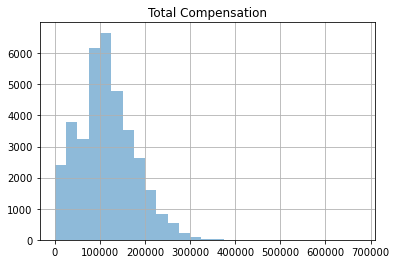

In [282]:
sf_bins = np.arange(0, 700000, 25000)
sf2015.filter(['Total Compensation']).hist(bins=sf_bins, alpha=.5);

Хотя большая часть значений меньше 300 000 долл., некоторые из них ощутимо выше. Например, общая сумма заработной платы директора по инвестициям составляет почти 650 000 долл. Именно поэтому горизонтальная ось доходит до 700 000 долл.

In [283]:
sf2015.sort_values(by='Total Compensation', ascending=False)[:2]

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
19177,Calendar,2015,6,General Administration & Finance,RET,Retirement System,351.0,Municipal Executive Association - Miscellaneous,1100,Administrative & Mgmt (Unrep),...,46881,507831.6,0.00,0.00,507831.60,105052.98,12424.5,23566.16,141043.64,648875.24
13194,Calendar,2015,6,General Administration & Finance,ADM,General Services Agency - City Admin,164.0,Physicians and Dentists - Miscellaneous,2500,Med Therapy & Auxiliary,...,1016,279311.1,3829.36,114433.58,397574.04,56211.64,12424.5,14299.10,82935.24,480509.28


За параметр примем медиану общих сумм заработной платы.

Поскольку нам повезло и у нас есть данные по всей генеральной совокупности, мы можем его вычислить:

In [284]:
pop_median = np.percentile(sf2015[['Total Compensation']], q=50)
pop_median

110305.79

Медианная общая сумма заработной платы всех работников составила чуть больше $110 300 долл.

С практической точки зрения причин делать выборку для оценки этого параметра у нас нет, поскольку его значение нам уже известно. Но в этом разделе мы сделаем вид, что не знаем этого значения, и посмотрим, насколько точно мы сможем его оценить по случайно выборке.

В последующих разделах мы вернемся с небес на землю и разберем ситуации, когда параметр неизвестен. Ну а пока мы знаем все.

## Случайная выборка и оценка
Сделаем выборку из 500 работников в случайном порядке без перестановки и примем медианную общую сумму заработной платы попавших в выборку работников за нашу оценку параметра.

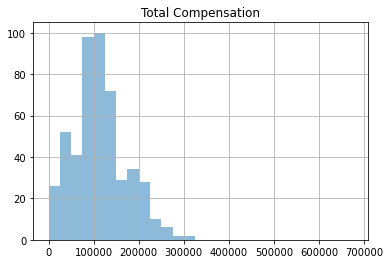

In [285]:
our_sample = sf2015.sample(500)
our_sample.filter(['Total Compensation']).hist(bins=sf_bins, alpha=.5);

In [286]:
est_median = np.percentile(our_sample[['Total Compensation']], 50)
est_median

108216.18

Выборка большая. По закону больших чисел распределение выборки отражает распределение популяции, а значит, медиана выборки не должна намного отличаться от медианы генеральной совокупности (хотя и не обязана с ней совпадать).

Таким образом, у нас есть одна оценка параметра. Однако, если бы в выборку попали другие работники, оценка была бы другой. Мы хотим выяснить, насколько может варьировать оценка в различных выборках. Эта мера вариативности позволит нам определить, насколько точно мы можем оценить параметр.

Чтобы понять, как изменилась бы оценка при другой выборке, можно просто сделать другую выборку из генеральной совокупности, но сейчас нам такой вариант не подходит. Мы пытаемся сымитировать реальную жизнь, где у нас не будет данных по всей генеральной совокупности.

Нам нужно получить другую случайную выборку, не делая выборку из генеральной совокупности.

## Бутстрэп, перестановка выборки
Итак, у нас есть большая случайная выборка из генеральной совокупности. Как нам теперь известно, большая случайная выборка обычно отражает генеральную совокупность, из которой она была сделана. Это наблюдение позволяет специалистам по обработке и анализу данных использовать _бутстрэп_ (от англ. lift oneself up by the bootstraps, что в дословном переводе означает "вытянуть себя за ремешки на ботинках", а по сути повторяет историю барона Мюнхгаузена, который вытащил себя из болота, потянув за собственные волосы): процедуру выборки можно повторить _сделав выборку из выборки_.

Метод бутстрэпа состоит из следующих шагов по составлению новой случайной выборки, отражающей генеральную совокупность:

- Принять исходную выборку за генеральную совокупность.
- Выбрать из этой выборки случайное значение с заменой столько раз, сколько позиций включает исходная выборка.

Важно повторить это действие столько же раз, сколько позиций включает исходная выборка. Это связано с тем, что вариативность оценки зависит от размера выборки. Поскольку исходная выборка включает 500 работников, медиана этой выборки была основана на 500 значениях. Чтобы понять, насколько может отличаться выборка, сравним ее с медианой других выборок из 500 позиций.

Если мы 500 раз выберем из нашей выборки из 500 позиций случайное значение без замены, то получим просто ту же самую выборку. Делая выборку с заменой, мы создаем вероятность того, что новые выборки будут отличаться от исходной, поскольку какие-то работники могут выпасть больше одного раза, а какие-то могут не выпасть совсем.

Что это дает? По закону больших чисел распределение исходной выборки обычно отражает генеральную совокупность, а распределения всех повторных выборок обычно отражают исходную выборку. Таким образом, распределения всех повторных выборок должны отражать и всю генеральную совокупность.

![](./media/65-bootstrap-25-0.png)

## Медиана повторной выборки
Напомним, что, если метод `sample` применяется с параметром `frac=1`, размер выборки будет равен количеству строк в таблице, из которой составляется выборка. Для бутстрэпа как раз это и нужно. Вот еще одна новая выборка, сформированная из исходной выборки, и соответствующая медиана.

In [287]:
resample_1 = our_sample.sample(frac=1, replace=True)

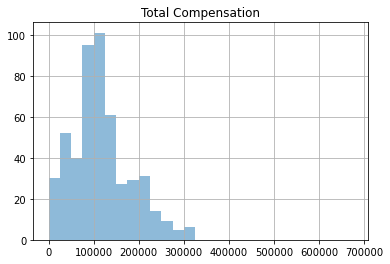

In [288]:
resample_1.filter(['Total Compensation']).hist(bins=sf_bins, alpha=.5);

In [289]:
resampled_median_1 = np.percentile(resample_1['Total Compensation'], 50)
resampled_median_1

109347.7

С повторной выборкой мы получаем еще одну оценку медианы генеральной совокупности. Повторяя создание выборки снова и снова, мы получим много таких оценок, а следовательно, и эмпирическое распределение этих оценок.

In [290]:
resample_2 = our_sample.sample(frac=1, replace=True)
resampled_median_2 = np.percentile(resample_2['Total Compensation'], 50)
resampled_median_2

109832.1

## Эмпирическое распределение медианы выборки при использовании бутстрэпа
Определим функцию `bootstrap_median`, которая берет нашу исходную выборку, метку столбца, содержащего переменную, и необходимое нам количество выборок методом бутстрэпа и возвращает массив соответствующих медиан повторных выборок.

С каждой повторной выборкой и вычислением медианы мы реплицируем процесс бутстрэпа. В связи с этим количество выборок методом бутстрэпа будет называться числом репликаций.

In [291]:
def bootstrap_median(original_sample, label, replications):
    """Returns an array of bootstrapped sample medians:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    just_one_column = original_sample.filter([label])
    medians = np.zeros(replications)
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample(frac=1, replace=True)
        resampled_median = np.percentile(bootstrap_sample, 50)
        medians[i] = resampled_median
        
    return medians

Реплицируем процесс бутстрэпа 5000 раз. Медианы всех 5000 выборок методом бутстрэпа будут добавлены в массив `bstrap_medians`. Обратите внимание, что этот код выполняется дольше, чем наш предыдущий код. Ему нужно сделать большое количество повторных выборок.

In [292]:
bstrap_medians = bootstrap_median(our_sample, 'Total Compensation', 5000)

Посмотрим на гистограмму 5000 медиан. Красной точкой обозначен параметр генеральной совокупности — медиана всей генеральной совокупности, которую мы знали, но не использовали в процессе бутстрэпа.

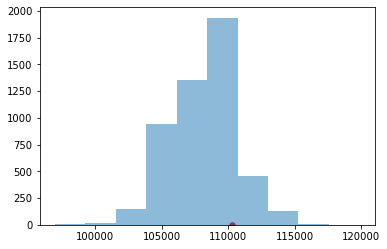

In [293]:
#median_bins=np.arange(100000, 130000, 2500)
#resampled_medians.hist(bins = median_bins)
plt.hist(bstrap_medians, alpha=.5)
plt.scatter(pop_median, 0, color='red', s=30);

Важно помнить, что красная точка постоянна и соответствует $110 305,79 — медиане генеральной совокупности. Эмпирическая гистограмма — это результат случайных выборок, а значит, ее расположение относительно красной точки случайно.

Напомним также, что цель этих вычислений — дать примерную оценку медианы генеральной совокупности, т. е. красной точки. Наши оценки — это медианы всех наших случайных выборок, гистограмма которых приводится выше. Нам нужно, чтобы эти оценки содержали параметр, иначе они бессмысленны.

## Включают ли оценки параметр?
Как часто бывает, что эмпирическая гистограмма медиан повторных выборок уверенно седлает красную точку, а не просто до нее дотягивается? Чтобы ответить на этот вопрос, необходимо определиться, что мы понимаем под словом "седлать". Пусть оно означает, что "средние 95% медиан повторных выборок включают красную точку".

Вот два конца интервала средних 95% медиан повторных выборок:

In [294]:
left = np.percentile(bstrap_medians, 2.5)
left

102748.15149999999

In [295]:
right = np.percentile(bstrap_medians, 97.5)
right

113281.417875

Медиана генеральной совокупности, $110 305, находится между двумя этими числами. Интервал и медиана генеральной совокупности показаны на приведенной ниже гистограмме.

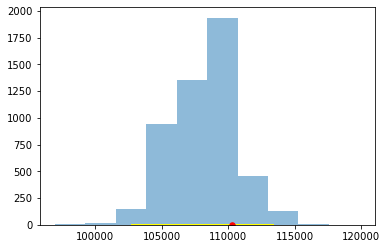

In [296]:
#median_bins=np.arange(100000, 130000, 2500)
#resampled_medians.hist(bins = median_bins)
plt.hist(bstrap_medians, alpha=.5)
plt.plot(np.array([left, right]), np.array([0, 0]), color='yellow', lw=3, zorder=1)
plt.scatter(pop_median, 0, color='red', s=30, zorder=2);

Параметр в нашем примере попал в интервал средних 95 % оценок. Однако не было ли это случайностью?

Чтобы увидеть, как часто интервал содержит параметр, необходимо многократно повторить весь процесс. В данном случае мы 100 раз повторим следующий процесс:

- Получим исходную выборку из генеральной совокупности, содержащую 500 позиций.
- Выполним 5000 репликаций процесса бутстрэпа и получим интервал средних 95% медиан повторных выборок.

В итоге мы получим 100 интервалов и вычислим, сколько из них содержат медиану генеральной совокупности.

Внимание, спойлер! В статистической теории бутстрэп подразумевает, что это количество должно быть около 95. Он может быть ближе к 90 или к 100, но не должно выходить за эти пределы.

In [297]:
# Generate 100 intervals, in the table intervals

left_ends = np.zeros(100)
right_ends = np.zeros(100)

total_comps = sf2015.filter(['Total Compensation'])

for i in np.arange(100):
    first_sample = total_comps.sample(500)
    medians = bootstrap_median(first_sample, 'Total Compensation', 5000)
    left_ends[i] = np.percentile(medians, 2.5)
    right_ends[i] = np.percentile(medians, 97.5)

intervals = pd.DataFrame(zip(left_ends, right_ends), columns=['Left', 'Right'])

Для каждой из 100 репликаций мы получим один интервал оценок медианы.

In [298]:
intervals

,Left,Right
0,107747.645000,119469.56000
1,101072.592125,111983.46000
2,110318.840000,123508.53000
3,107012.710000,118588.25000
4,97782.970000,108759.66000
...,...,...
95,100076.215000,113708.48000
96,101720.310000,119052.44000
97,102238.670000,113981.18500
98,105534.855000,119504.68000


Хорошие интервалы — это интервалы, содержащие параметр, который мы пытаемся оценить. Обычно параметр неизвестен, но в этом разделе мы его знаем.

In [299]:
pop_median

110305.79

In [300]:
intervals.query('Left < @pop_median < Right')

,Left,Right
0,107747.645000,119469.56000
1,101072.592125,111983.46000
3,107012.710000,118588.25000
5,100062.145000,112943.33000
6,105639.490000,117458.15000
...,...,...
95,100076.215000,113708.48000
96,101720.310000,119052.44000
97,102238.670000,113981.18500
98,105534.855000,119504.68000


Создание всех интервалов занимает несколько минут, но, если вам хватит терпения, повторите всю процедуру еще раз. Скорее всего, примерно 95 из 100 окажутся хорошими, т. е. будут содержать параметр.

Отображение всех интервалов на горизонтальной оси затрудняет то, что они сильно накладываются друг на друга — в конце концов, все должны дать оценку одного и того же параметра. На представленном ниже графике все интервалы показаны на одних и тех же осях за счет вертикального размещения. Вертикальная ось — это номер репликации, из которой был получен интервал.

Красная линия — это параметр. Хорошие интервалы захватывают параметр — обычно их около 95.

Если интервал не захватывает параметр, он плохой. Плохими считаются интервалы, которые не пересекаются с красной линией. Обычно их мало, около 5, но они бывают.

Любой метод на основе выборок может дать осечку. Преимущество методов на основе случайных выборок в том, что количество возможных осечек можно рассчитать.

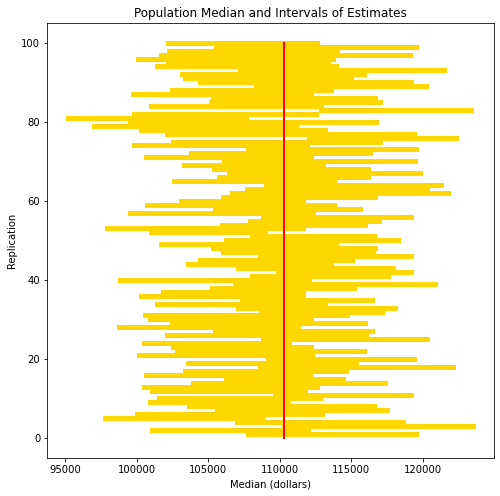

In [301]:
intervals2 = pd.DataFrame(np.array([left_ends, right_ends]))

plt.figure(figsize=(8,8))
for i in np.arange(100):
    ends = intervals2[[i]]
    plt.plot(ends, np.array([i+1, i+1]), color='gold', lw=5)
plt.plot(np.array([pop_median, pop_median]), np.array([0, 100]), color='red', lw=2)
plt.xlabel('Median (dollars)')
plt.ylabel('Replication')
plt.title('Population Median and Intervals of Estimates');

Чтобы описать, что показывает эта модель, предположим, что вы оцениваете медиану генеральной совокупности следующим образом.

- Делаете большую случайную выборку из генеральной совокупности.
- Применяете к случайной выборке процесс бутстрэпа и получаете оценку из новой случайной выборки.
- Повторяете указанные выше шаги тысячи раз и получаете тысячи оценок.
- Выбираете интервал их "средних 95%" всех оценок.

В результате вы получаете один интервал оценок. Если вы повторите **весь процесс** 100 раз и получите 100 интервалов, то около 95 из этих 100 интервалов будут содержать параметр генеральной совокупности.

Другими словами, процесс оценки захватывает параметр примерно в 95% случаев.

Можно заменить 95% другим значением меньше 100. Предположим, что вы заменили 95% на 80% и оставили размер выборки прежним — 500. В этом случае интервалы оценок будут короче, чем в представленной выше модели, поскольку диапазон "средних 80%" меньше, чем "средних 95%". Параметр будут содержать только 80% интервалов.

# Доверительные интервалы

Мы разработали метод для оценки параметра с использованием случайной выборки и бутстрэпа. Метод создает интервал оценок с учетом случайной изменчивости в случайной выборке. Наличие целого интервала оценок, а не одной единственной оценки дает пространство для маневров.

В предыдущем примере наш процесс оценки давал хороший интервал, т. е. интервал захватывал параметр, примерно в 95% случаев. И тогда мы говорим, что на 95% уверены в том, что процесс дает хороший интервал. Наш интервал оценок называется 95%-м _доверительным интервалом_ для параметра, а 95% — _доверительным интервалом_.

Ситуация, описанная в предыдущем примере, была довольно необычна. Поскольку мы знали значение параметра, то смогли проверить, был ли интервал хорошим или плохим, что, в свою очередь, позволило нам увидеть, что наш процесс оценки захватывает параметр примерно в 95 из каждых 100 случаев его применения.

Обычно специалисты по обработке и анализу данных не узнают значение параметра. Именно поэтому им и нужно его оценить. В таких ситуациях они предоставляют интервал оценок для неизвестного параметра, используя методы, подобные тому, что разработали мы. Благодаря статистической теории и демонстрациям, подобным тем, что мы рассмотрели, специалисты по обработке и анализу данных могут быть уверены в том, что их процесс создания интервала дает хороший интервал в известной доле случаев.

## Доверительный интервал для медианы генеральной совокупности, метод бутстреп-процентилей
Теперь мы применим метод бутстрэпа для оценки медианы неизвестной генеральной совокупности. Данные взяты из выборки новорожденных в одной из крупной сети больниц. Мы будем работать с ней как с простой случайной выборкой, хотя процесс ее формирования проводился в несколько этапов. Информацию о более крупном наборе данных, из которого взята эта выборка, см. в книге Stat Labs Деборы Нолан (Deborah Nolan) и Терри Спида (Terry Speed).

Таблица `baby` содержит следующие переменные для пар "мать — ребенок": вес ребенка при рождении в унциях, гестационный возраст в днях, возраст матери (полных лет), рост матери в дюймах, вес во время беременности в фунтах, а также сведения о том, курила ли мать во время беременности.

In [302]:
baby = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/baby.csv')
baby

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
...,...,...,...,...,...,...
1169,113,275,27,60,100,False
1170,128,265,24,67,120,False
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False


Вес при рождении — важный показатель здоровья новорожденного: детям с меньшим весом обычно требуется больше медицинской помощи в первые дни жизни, чем более крупным новорожденным. В связи с этим оценка веса при рождении до того, как ребенок родится, может быть полезна. Один из способов решения этой задачи — изучить взаимосвязь между весом новорожденного и количеством дней беременности.

Простая мера этой взаимосвязи представляет собой соотношение веса при рождении и количества дней беременности. Таблица `ratios` содержит первые два столбца таблицы `baby`, а также столбец соотношений. Первая запись в этом столбце была вычислена следующим образом: 120 унц./284 дн. ≈ 0,4225 унц./день

In [303]:
baby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Birth Weight               1174 non-null   int64
 1   Gestational Days           1174 non-null   int64
 2   Maternal Age               1174 non-null   int64
 3   Maternal Height            1174 non-null   int64
 4   Maternal Pregnancy Weight  1174 non-null   int64
 5   Maternal Smoker            1174 non-null   bool 
dtypes: bool(1), int64(5)
memory usage: 47.1 KB


In [304]:
ratios = baby.filter(['Birth Weight', 'Gestational Days'])
ratios['Ratio BW/GD'] = ratios['Birth Weight'] / ratios['Gestational Days']
ratios

,Birth Weight,Gestational Days,Ratio BW/GD
0,120,284,0.422535
1,113,282,0.400709
2,128,279,0.458781
3,108,282,0.382979
4,136,286,0.475524
...,...,...,...
1169,113,275,0.410909
1170,128,265,0.483019
1171,130,291,0.446735
1172,125,281,0.444840


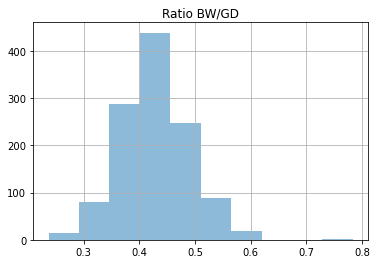

In [305]:
ratios.filter(['Ratio BW/GD']).hist(alpha=.5);

На первый взгляд, гистограмма симметрична с максимальной плотностью значений в интервале от 4 до 4,5 унций в день. Однако при более внимательном изучении окажется, что некоторые соотношения сравнительно больше. Максимальное значение соотношений оказалось больше 0,78 унции в день, что почти вдвое больше типового значения.

In [306]:
ratios.sort_values('Ratio BW/GD', ascending=False)[:1]

,Birth Weight,Gestational Days,Ratio BW/GD
238,116,148,0.783784


Медиана отражает типовое соотношение, поскольку на нее влияют слишком большие или маленькие соотношения. Медианное соотношение в этой выборке составляет около 0,429 унции в день.

In [307]:
ratios['Ratio BW/GD'].median()

0.42907801418439717

Но какова была медиана генеральной совокупности? Мы не знаем, поэтому вычислим ее приблизительно.

Метод будет точно таким же, как в предыдущем разделе. Мы повторим процесс бутстрэпа 5000 раз и получим 5000 оценок медианы. Наш 95%-й доверительный интервал составят средние 95% всех наших оценок.

Вызовем функцию `bootstrap_median`, определенную в предыдущем разделе. Вызвав эту функцию, мы получим 95%-й доверительный интервал для медианного соотношения в генеральной совокупности. Как вы помните, таблица `ratios` содержит релевантные данные из нашей исходной выборки.

In [308]:
# Generate the medians from 5000 bootstrap samples
bstrap_medians = bootstrap_median(ratios, 'Ratio BW/GD', 5000)

In [309]:
# Get the endpoints of the 95% confidence interval
left = np.percentile(bstrap_medians, 2.5)
right = np.percentile(bstrap_medians, 97.5)

np.array([left, right])

array([0.42545455, 0.43272727])

В 95%-й доверительный интервал входят значения от 0,425 до 0,432 унции в день. Судя по нашей оценке, медианное соотношение "веса рождения и количества дней беременности" в генеральной совокупности находится где-то в диапазоне от 0,425 до 0,432 унции в день.

Оценка 0,429 согласно исходной выборке приходится ровно на середину интервала между этими двумя значениями, хотя в целом это не значит, что она верна.

Для наглядности построим эмпирическую гистограмму с начальными значениями медиан, полученных с помощью бутстрэпа, и отложим доверительный интервал на горизонтальной оси.

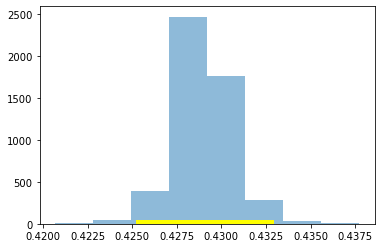

In [310]:
plt.hist(bstrap_medians, bins=8, alpha=.5)
plt.plot(np.array([left, right]), np.array([0, 0]), color='yellow', lw=8);

Гистограмма и интервал похожи на то, что мы получили в предыдущих главах, с одним существенным отличием: нет красной точки, указывающей местонахождение параметра. Мы не знаем, где должна быть эта точка и попадает ли она в интервал.

У нас есть только интервал оценок. Доверительный интервал составляет 95%, поскольку процесс его получения дает хороший интервал примерно в 95% случаев. Это гораздо лучше, чем гадать вслепую.

Помните, что этот интервал примерно соответствует 95 %-му доверительному интервалу. В этом вычислении много приближений. Приближение само по себе неплохо, но не является точным.

## Доверительный интервал для среднего по совокупности: метод бутстрэп-процентилей
Так же, как определяли медианы, можно определить и средние арифметические. Допустим, мы хотим оценить средний возраст матерей в генеральной совокупности. Логично будет для этого оценить средний возраст матерей в выборке. На гистограмме ниже показано распределение их возрастов, а также их средний возраст, который составил около 27,2 года.

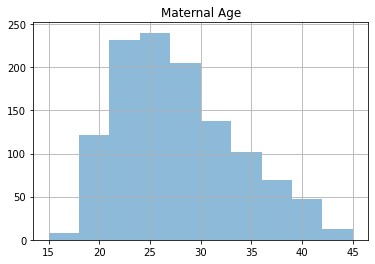

In [311]:
baby.filter(['Maternal Age']).hist(alpha=.5);

In [312]:
baby['Maternal Age'].mean()

27.228279386712096

Каков средний возраст матерей в генеральной совокупности? Значение этого параметра нам не известно.

Рассчитаем неизвестный параметр методом бутстрэпа. Для этого необходимо изменить код для `bootstrap_median`, определив в нем функцию `bootstrap_mean`. Код будет тем же самым, за исключением того что статистика будет содержать средние значения, а не медианы и собираться в массив с именем `means`, а не `medians`.

In [313]:
def bootstrap_mean(original_sample, label, replications):
    
    """Returns an array of bootstrapped sample means:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    just_one_column = original_sample.filter([label])
    means = np.zeros(replications)
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample(frac=1, replace=True)
        resampled_mean = np.mean(bootstrap_sample)
        means[i] = resampled_mean
        
    return means

In [314]:
# Generate the means from 5000 bootstrap samples
bstrap_means = bootstrap_mean(baby, 'Maternal Age', 5000)

# Get the endpoints of the 95% confidence interval
left = np.percentile(bstrap_means, 2.5)
right = np.percentile(bstrap_means, 97.5)

np.array([left, right])

array([26.89520869, 27.54942504])

Доверительный интервал в 95% включает возраст от 27,1 до 27,3 года. Таким образом, можно сказать, что средний возраст матерей в генеральной совокупности находится в интервале от 27,1 до 27,3 года.

Обратите внимание, насколько близки два крайних значения к среднему значению исходной выборки — 27,2 года. Выборка большая, включает 1174 матери, поэтому средние значения выборок существенно не меняются. Рассмотрим это наблюдение более подробно в следующей главе.

Ниже показана эмпирическая гистограмма 5000 средних значений, полученных методом бутстрэпа, а также 95-процентный доверительный интервал для среднего по совокупности.

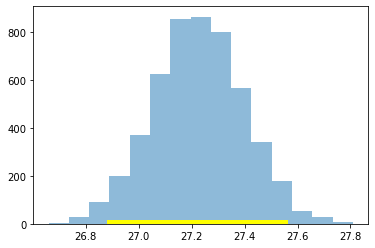

In [315]:
plt.hist(bstrap_means, bins=15, alpha=.5)
plt.plot(np.array([left, right]), np.array([0, 0]), color='yellow', lw=8);

Среднее значение исходной выборки (27,22 года) снова находится близко к середине интервала. Это не удивительно, поскольку каждая выборка, полученная методом бутстрэпа, получена из исходной выборки. Средние значения выборок, полученных методом бутстрэпа, довольно симметрично распределены по обеим сторонам среднего значения выборки, из которой были сделаны эти выборки.

Также следует отметить, что эмпирическая гистограмма средних повторных выборок имеет довольно симметричную колоколообразную форму, хотя гистограмма возрастов в выборке совсем не симметрична:

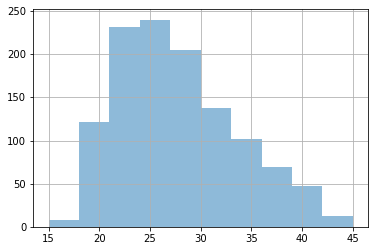

In [316]:
baby['Maternal Age'].hist(alpha=.5);

Это следствие центральной предельной теоремы вероятности и статистики. Суть этой теоремы мы рассмотрим в последующих разделах.

## 80%-й доверительный интервал
На основе средних значений выборок, полученных методом бутстрэпа, можно построить любой доверительный интервал. Например, чтобы получить 80%-й доверительный интервал для среднего возраста в генеральной совокупности, можно взять средние 80% средних значений повторных выборок. В этом случае по 10% распределения должны приходиться на каждую из двух сторон графика, а значит, конечные точки будут соответствовать 10-му и 90-му процентилям средних значений повторных выборок.

In [317]:
left_80 = np.percentile(bstrap_means, 10)
right_80 = np.percentile(bstrap_means, 90)
left_80, right_80

(27.008517887563883, 27.443781942078363)

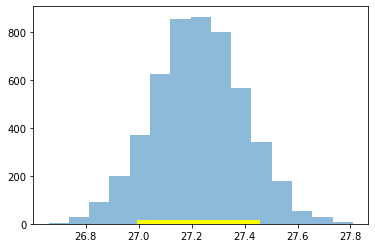

In [318]:
plt.hist(bstrap_means, bins=15, alpha=.5)
plt.plot(np.array([left_80, right_80]), np.array([0, 0]), color='yellow', lw=8);

Такой 80-процентный доверительный интервал намного меньше, чем 95-процентный. В него входит только диапазон от 27,15 до 27,30 года. Хотя такой набор оценок не строгий, этот процесс, как вы уже знаете, дает хороший интервал только примерно в 80 % случаев.

Предыдущий процесс дал более широкий интервал, зато мы были больше уверены в процессе его получения.

Чтобы получить более узкий доверительный интервал с высоким уровнем уверенности, исходная выборка должна быть больше. В следующей главе мы узнаем, почему.

## Доверительный интервал для доли популяции, метод бутстрэп-процентилей
В нашей выборке 39% матерей курили во время беременности.

In [319]:
baby.query('`Maternal Smoker` == True').__len__() / len(baby)

0.3909710391822828

Используя операцию массива можно также рассчитать следующее:

In [320]:
smoking = baby['Maternal Smoker']
np.count_nonzero(smoking) / len(smoking)

0.3909710391822828

Какой процент матерей в популяции курил во время беременности? Это неизвестный параметр, который можно оценить, используя доверительный интервал бутстрэпа. В этом случае выполняются те же действия, что и для оценки среднего и медианы по совокупности.

Начнем с определения функции `bootstrap_proportion`, возвращающей массив процентов из выборок, полученных методом бутстрэпа. Для этого снова отредактируем определение функции `bootstrap_median`. Единственное, что нам нужно изменить в вычислении, — это заменить медиану повторной выборки на процент курящих. Код предполагает, что столбец с данными содержит логические значения. Другие изменения относятся только к именам массивов, чтобы нам было проще читать и понимать код.

In [321]:
def bootstrap_proportion(original_sample, label, replications):
    
    """Returns an array of bootstrapped sample proportions:
    original_sample: table containing the original sample
    label: label of column containing the Boolean variable
    replications: number of bootstrap samples
    """
    
    just_one_column = original_sample[label]
    proportions = np.zeros(replications)
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample(frac=1, replace=True)
        resample_array = bootstrap_sample.values
        resampled_proportion = np.count_nonzero(resample_array) / len(resample_array)
        proportions[i] = resampled_proportion        
    
    return proportions

Используя функцию `bootstrap_proportion`, построим 95%-й доверительный интервал для процента курящих матерей в генеральной совокупности. Код будет похож на соответствующий код для определения среднего и медианы.

In [322]:
# Generate the proportions from 5000 bootstrap samples
bstrap_props = bootstrap_proportion(baby, 'Maternal Smoker', 5000)

# Get the endpoints of the 95% confidence interval
left = np.percentile(bstrap_props, 2.5)
right = np.percentile(bstrap_props, 97.5)

np.array([left, right])

array([0.36284072, 0.41822828])

Доверительный интервал включает значения от примерно 36 до примерно 42%. Значение исходной выборки, 39%, близко к центру интервала, как видно ниже.

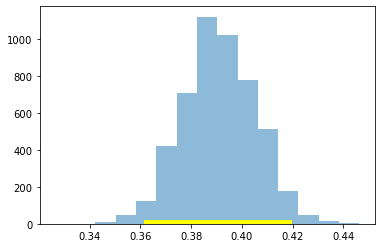

In [323]:
plt.hist(bstrap_props, bins=15, alpha=.5)
plt.plot(np.array([left, right]), np.array([0, 0]), color='yellow', lw=8);

## Меры предосторожности при применении метода бутстрэпа
Метод бутстрэпа изысканный и эффективный. Но прежде чем его использовать, необходимо принять во внимание несколько моментов.

- Для начала нужна большая случайная выборка. В противном случае метод работать не будет. Успешное применение метода требует больших случайных выборок (а следовательно, и повторных выборок на их основе), отражающих генеральную совокупность. По закону больших чисел это должно быть верно, если случайная выборка большая.

- Чтобы приблизительно вычислить вероятность распределения статистики, нужно реплицировать процедуру повторной выборки как можно больше раз. Несколько тысяч репликаций позволят получить адекватные приблизительные значения медианы выборки, особенно если распределение генеральной совокупности имеет одну точку максимума и не симметрично. Мы использовали в примерах 5000 репликаций, но в целом рекомендуем реплицировать выборки 10 000 раз.

- Метод бутстрэп-процентилей хорошо подходит для оценки медианы или среднего по совокупности на основе большой случайной выборки. Однако у него, как у всех методов оценки, есть ограничения. Например, он не будет работать в следующих ситуациях.

  - Необходимо оценить минимальное и максимальное значения в генеральной совокупности, очень низкий или очень высокий процентиль или параметры, на которые сильно влияют редкие элементы генеральной совокупности.
  - Распределение вероятностей в статистических данных не имеет примерно колоколообразную форму.
  - Исходная выборка невелика, например, число элементов в ней не превышает 10 или 15.

# Использование доверительных интервалов
Доверительный интервал имеет одну единственную цель — это оценка неизвестного параметра, исходя из данных случайной выборки. В прошлом блоке мы говорили, что интервал (36–42%) составляет примерно 95%-й доверительный интервал для процента курящих матерей в генеральной совокупности. В переводе на простой язык это будет означать, что, по нашим оценкам, доля курящих матерей в генеральной совокупности составляет от 36 до 42% и наша процедура оценки была верна примерно в 95% случаев.

Не поддавайтесь соблазну использовать доверительные интервалы в любых других целях. Например, вспомните: мы рассчитывали интервал (26,9–27,6 года) как примерно 95%-й доверительный интервал для среднего возраста матерей в генеральной совокупности. Крайне распространенная ошибка в применении интервала приводит к выводу о том, что 95% женщин находятся в возрасте от 26,9 до 27,6 года. Не нужно разбираться в доверительных интервалах хорошо, чтобы понять, что это не может быть правдой — невозможно, чтобы 95% матерей отличались друг от друга по возрасту всего на несколько месяцев. На самом деле гистограмма возрастов в выборке демонстрирует довольно широкое расхождение.

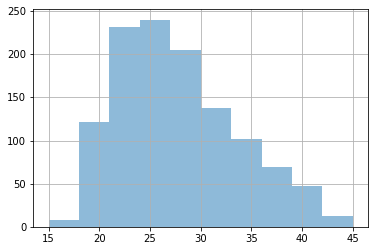

In [324]:
baby['Maternal Age'].hist(alpha=.5);

Небольшой процент возрастов в выборке попадает в интервал (26,9–27,6), и можно предположить, что в генеральной совокупности этот процент будет таким же низким. Интервал определяет только одно число — среднее арифметическое всех простоев в генеральной совокупности.

При этом оценка того или иного параметра по доверительным интервалам не только позволяет примерно понимать, насколько важен этот параметр, но и имеет одно важное применение.

## Применение доверительного интервала для проверки гипотез
Наш примерно 95%-й доверительный интервал для среднего возраста в генеральной совокупности охватывает диапазон от 26,9 до 27,6 года. Допустим, кто-то хочет проверить следующие гипотезы:

__Нулевая гипотеза.__ Средний возраст в генеральной совокупности — 30 лет.

__Альтернативная гипотеза.__ Средний возраст в генеральной совокупности — не 30 лет.

Если при этом для P-значения используется уровень значимости 5%, нулевую гипотезу следует отвергнуть. Это связано с тем, что 30-летний возраст не попадает в 95 %-й доверительный интервал для среднего возраста генеральной совокупности. При 5%-м уровне значимости 30-летний возраст не является правдоподобным значением для среднего возраста генеральной совокупности.

Такое использование доверительных интервалов возникает в результате дуальности между ними и тестами. Если вы проверяете, соответствует ли среднее по совокупности определенному значению $x$, а для P-значения используется уровень значимости 5%, нулевую гипотезу следует отвергнуть, если $x$ не попадает в 95 %-й доверительный интервал для среднего арифметического.

Это можно установить, используя статистическую теорию. На практике все сводится к проверке того, попадает ли значение, указанное в нулевой гипотезе, в доверительный интервал.

Если для P-значения используется уровень значимости 1%, необходимо проверить, попадает ли указанное в нулевой гипотезе значение в 99%-й доверительный интервал для среднего по совокупности.

При грубом приближении эти утверждения также справедливы для долей популяции при условии, что выборка большая.

Теперь у нас есть способ использовать доверительные интервалы для проверки определенного рода гипотез, но у вас может возникнуть вопрос о ценности проверки того, соответствует ли средний возраст в генеральной совокупности 30 годам. Ценность действительно не ясна. Однако бывают ситуации, когда подобные проверки гипотез и естественны, и полезны.

Рассмотрим для примера данные, представляющие собой подмножество информации, собранной в ходе рандомизированного контролируемого исследования методов лечения лимфомы Ходжкина. Лимфома Ходжкина — это рак, который обычно поражает молодых. Эта болезнь излечима, но лечение может быть очень тяжелым. Исследование проводилось с целью подобрать дозировку, достаточную для лечения рака и при этом вызывающую минимум побочных эффектов у пациентов.

В таблице `hodgkins` представлены данные о влиянии лечения на легкие 22 пациентов. Столбцы:

- Рост в см
- Доза облучения в мантийной зоне (шея, грудная клетка, подмышки)
- Доза химиотерапии
- Оценка состояния легких на исходном уровне, т. е. в начале лечения; чем выше оценка, тем лучше состояние легких
- Та же оценка состояния легких, но через 15 месяцев после начала лечения

In [325]:
hodgkins = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/inferentialthinking/master/data/hodgkins.csv')

In [326]:
hodgkins.head()

,height,rad,chemo,base,month15
0,164,679,180,160.57,87.77
1,168,311,180,98.24,67.62
2,173,388,239,129.04,133.33
3,157,370,168,85.41,81.28
4,160,468,151,67.94,79.26


Мы будем сравнивать показатели на исходном уровне и через 15 месяцев. Так как каждая строка соответствует одному пациенту, мы говорим, что оценки на исходном уровне и через 15 месяцев лечения являются парными — это не просто два набора из 22 значений, а 22 пары значений, по одной для каждого пациента.

Сразу видно, что оценки через 15 месяцев лечения в основном ниже, чем оценки на исходном уровне, т. е. через 15 месяцев после начала лечения состояние пациентов ухудшилось. Это подтверждают в основном положительные значения в столбце `drop` — то, насколько упала оценка состояния через 15 месяцев лечения по сравнению с исходным уровнем.

In [327]:
hodgkins['drop'] = hodgkins['base'] - hodgkins['month15']
hodgkins.head()

,height,rad,chemo,base,month15,drop
0,164,679,180,160.57,87.77,72.80
1,168,311,180,98.24,67.62,30.62
2,173,388,239,129.04,133.33,-4.29
3,157,370,168,85.41,81.28,4.13
4,160,468,151,67.94,79.26,-11.32


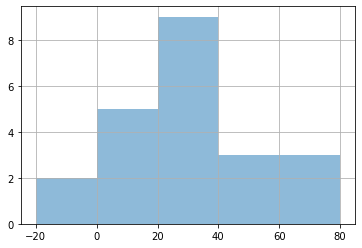

In [328]:
hodgkins['drop'].hist(bins=np.arange(-20, 81, 20), alpha=.5);

In [329]:
hodgkins['drop'].mean()

28.615909090909096

Но не может ли это быть следствием случайной вариации? Скорее всего нет, хотя данные получены из случайной выборки. Возможно ли, что в рамках всей совокупности пациентов среднее снижение оценки будет нулевым?

Для ответа на этот вопрос сформулируем две гипотезы:

__Нулевая гипотеза.__ Во всей генеральной совокупности среднее снижение оценки — 0.

__Альтернативная гипотеза.__ Во всей генеральной совокупности среднее снижение оценки — не 0.

Чтобы проверить эту гипотезу, используя для P-значения уровень значимости 1%, создадим для среднего снижения оценки в генеральной совокупности примерно 99-процентный доверительный интервал.

In [330]:
bstrap_means = bootstrap_mean(hodgkins, 'drop', 10000)

left = np.percentile(bstrap_means, 0.5)
right = np.percentile(bstrap_means, 99.5)

np.array([left, right])

array([17.10544318, 40.71945682])

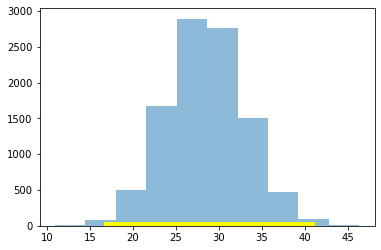

In [331]:
plt.hist(bstrap_means, alpha=.5)
plt.plot(np.array([left, right]), np.array([0, 0]), color='yellow', lw=8);

Доверительный интервал для среднего снижения оценки в генеральной совокупности, равный 99%, включает значения примерно от 17 до примерно 41. В этот интервал не входит значение 0, поэтому мы отвергаем нулевую гипотезу.

При этом мы не просто сделали вывод о том, что среднее снижение оценки в генеральной совокупности не равно 0, но и оценили, насколько оно существенно. Это гораздо полезнее, чем просто сказать, что определенный параметр не равен 0.

__Примечание о точности.__ Мы используем широкий доверительный интервал по двум основным причинам:
- Высокий уровень уверенности (99 %). 
- Размер выборки относительно небольшой по сравнению с предыдущими примерами.

В следующей главе мы рассмотрим, как размер выборки влияет на точность. Мы также обсудим, почему эмпирические распределения средних арифметических выборов часто имеют колоколообразную форму, даже если форма графика распределения исходных данных совершенно иная.